In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from qutip import Qobj
import qutip as qu
from tqdm import tqdm

from src.observables import entropy_vn

D = 30
TIMEDELTA = 1
SUFFIX = '.npy'

In [28]:
import os
os.getcwd()

'C:\\Users\\fedes\\UNIPA\\PHASEONIUM\\phaseonium-evolution\\notebooks'

In [29]:
def file_dims(filename):
    return int(filename.split('_')[-3][1:])


def file_time(filename):
    return int(filename.split('_')[-2][1:])


def file_timedelta(filename):
    return float(filename.split('_')[-1][2:])


def check_file_metadata(filename):
    dims = file_dims(filename)
    timedelta = file_timedelta(filename)
    return dims == D and timedelta == TIMEDELTA

In [30]:
files = [file.removesuffix(SUFFIX) for file in os.listdir('../objects') if file.endswith(SUFFIX)]
times = [file_time(file) for file in files if check_file_metadata(file)]
times.sort()
print(f'Times: {times}')
rho_evolution = []
for t in tqdm(times):
    if SUFFIX=='.npz':
        try:
            rho_evolution_zip = np.load(f'../objects/rho_evolution_d{D}_t{t}_dt{TIMEDELTA}' + SUFFIX)
            rho_evolution_t = [rho_evolution_zip[t] for t in rho_evolution_zip.files]
            rho_evolution.extend(rho_evolution_t)
            print(len(rho_evolution))
        except MemoryError as e:
            print(e)
        break
    elif SUFFIX == '.npy':
        try:
            entropy_evolution = np.load(f'../objects/rho_entropy_D{D}_t{t}_dt{TIMEDELTA}' + SUFFIX)
            #  purity_evolution = np.load(f'../objects/rho_<//D{D}_t{t}_dt{TIMEDELTA}' + SUFFIX)
        except FileNotFoundError as e:
            print(e)

Times: [10000]


100%|██████████| 1/1 [00:00<00:00, 803.97it/s]


Last Density Matrix

In [31]:
last_rho = Qobj(rho_evolution[-1], dims=[[D, D], [D, D]])
print(last_rho.tr())
last_rho.ptrace(0)

IndexError: list index out of range

0it [00:00, ?it/s]


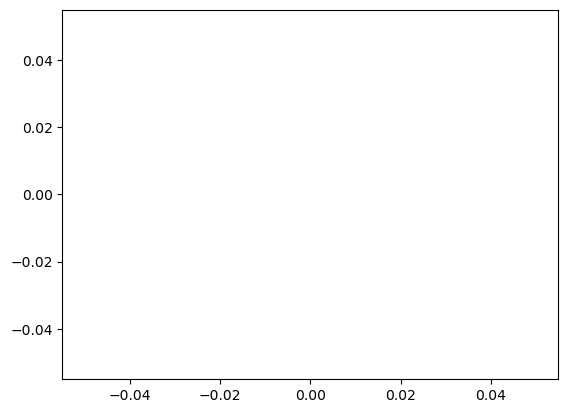

In [32]:
entropies = []
for rho in tqdm(rho_evolution):
    entropies.append(entropy_vn(rho))

plt.plot(entropies)

In [33]:
plt.savefig(f'img/rho_evolution_d{D}_t{t}_dt{TIMEDELTA}.png')

FileNotFoundError: [Errno 2] No such file or directory: 'img/rho_evolution_d30_t10000_dt1.png'

<Figure size 640x480 with 0 Axes>

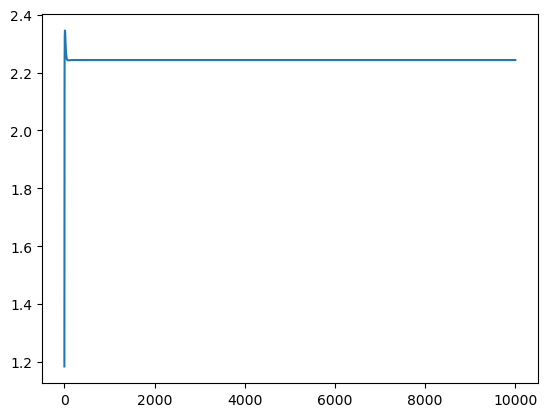

In [34]:
plt.plot(entropy_evolution)
plt.show()